# Candidate Test 2022 Analysis Part 2

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2). Consider normalizing the data or performing similar scaling transformations as needed.

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:

- An analysis/description of which questions are most crucial concerning their placement on the axes.
- Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.
- A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**
- An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.
- Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



- An analysis/description of which questions are most crucial concerning their placement on the axes.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
plt.rcParams['image.cmap'] = "gray"

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import (datasets, decomposition, ensemble, 
                     metrics, model_selection, preprocessing)

In [3]:
import pandas as pd

data = pd.read_excel('alldata.xlsx')
data = data.drop(columns='alder')
data = data.drop(columns='storkreds')
print(data.columns)

Index(['530', '531', '533', '534', '535', '537', '538', '540', '541', '543',
       '544', '545', '546', '547', '548', '550', '551', '552', '553', '555',
       '556', '557', '559', '561', '563', 'navn', 'parti', '1a', '1b', '2a',
       '2b', '3a', '3b', '4a', '4b', '5a', '5b', '6a', '6b', '7a', '7b', '8a',
       '8b', '9a', '9b', '10a', '10b', '11a', '11b', '12a', '12b'],
      dtype='object')


Just some rearranging for easier selection of questions_data

In [4]:
import pandas as pd

parti_col = data['parti']
navn_col = data['navn']
# Drop the columns 'parti' and 'navn'
data.drop(columns=['parti', 'navn'], inplace=True)

# Append the columns 'parti' and 'navn' to the end of the DataFrame
data['parti'] = parti_col
data['navn'] = navn_col
print(data.head())


   530  531  533  534  535  537  538  540  541  543  ...  9a  9b  10a  10b  \
0   -1   -2    1   -2    2    1   -2    1    1    2  ...   2   0    1   -2   
1    2    2   -1   -2   -1   -2    1   -2    2   -2  ...  -2   0   -1    2   
2    2    1   -2   -2    1   -2    1   -1    1   -1  ...  -1  -2    0    2   
3    2    1   -2   -1    1    1    1    1    1   -2  ...  -2   2    2    2   
4    1    1   -2    2   -2    1   -2    1    2   -2  ...  -2   0   -1    0   

   11a  11b  12a  12b                    parti                      navn  
0   -2    1    1    1              Moderaterne      Lars Philipsen Prahm  
1    1   -2    0    0  Socialistisk Folkeparti             Karsten Hønge  
2    0   -1    1   -2             Alternativet  Martin Kelleher-Petersen  
3    2   -1    2    0             Alternativet    Nicklas Gjedsig Larsen  
4   -2    0    2   -2                Løsgænger            Tom Gillesberg  

[5 rows x 51 columns]


In [5]:
index_of_parti = data.columns.get_loc('parti')
print(index_of_parti)
questions_data = data.iloc[:,:49]
questions_data.head()

49


,530,531,533,534,535,537,538,540,541,543,...,8a,8b,9a,9b,10a,10b,11a,11b,12a,12b
0,-1,-2,1,-2,2,1,-2,1,1,2,...,1,0,2,0,1,-2,-2,1,1,1
1,2,2,-1,-2,-1,-2,1,-2,2,-2,...,0,0,-2,0,-1,2,1,-2,0,0
2,2,1,-2,-2,1,-2,1,-1,1,-1,...,1,1,-1,-2,0,2,0,-1,1,-2
3,2,1,-2,-1,1,1,1,1,1,-2,...,2,2,-2,2,2,2,2,-1,2,0
4,1,1,-2,2,-2,1,-2,1,2,-2,...,1,0,-2,0,-1,0,-2,0,2,-2


In [6]:
# 4 columns of data (cm), going to use PCA
# with 4 columns of result.
# The explained_variance_ratio_ tells us that
# by using 1 principal component, we will get
# 73% of the variance
X = questions_data
print(X)
X_s = preprocessing.StandardScaler().fit_transform(X)
pca4 = decomposition.PCA(n_components=None)
res4 = pca4.fit_transform(X_s)
pca4.explained_variance_ratio_

     530  531  533  534  535  537  538  540  541  543  ...  8a  8b  9a  9b  \
0     -1   -2    1   -2    2    1   -2    1    1    2  ...   1   0   2   0   
1      2    2   -1   -2   -1   -2    1   -2    2   -2  ...   0   0  -2   0   
2      2    1   -2   -2    1   -2    1   -1    1   -1  ...   1   1  -1  -2   
3      2    1   -2   -1    1    1    1    1    1   -2  ...   2   2  -2   2   
4      1    1   -2    2   -2    1   -2    1    2   -2  ...   1   0  -2   0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ..  ..  ..  ..   
862    1    1    1   -2    2   -1    1   -2    1    1  ...   2   1   1   2   
863    1   -2   -2   -2    1   -2   -1   -2   -2   -2  ...   1   0  -1   0   
864    1    1    1   -2    2   -1    1   -1   -1    1  ...   1   0  -1   0   
865    1   -1    1   -2    1   -1   -1   -1   -1    1  ...   0   0   0   0   
866    1    1   -1   -2    1   -1    1   -1    1   -1  ...   1   1  -2  -1   

     10a  10b  11a  11b  12a  12b  
0      1   -2   -2    1    

array([0.41737636, 0.10259865, 0.04976015, 0.04300927, 0.0293233 ,
       0.0237033 , 0.01994712, 0.01697463, 0.01676652, 0.01608279,
       0.01527152, 0.01449084, 0.01303718, 0.01297392, 0.01200226,
       0.01125725, 0.0102922 , 0.00997773, 0.00986747, 0.00966786,
       0.00928391, 0.0089641 , 0.00877818, 0.00786085, 0.00755989,
       0.00722701, 0.00682415, 0.00670982, 0.00626662, 0.00605007,
       0.00582534, 0.0055948 , 0.0052595 , 0.00505699, 0.00473416,
       0.00466639, 0.00453667, 0.00416406, 0.00398844, 0.00388108,
       0.00341904, 0.00330379, 0.0029882 , 0.00290354, 0.00251036,
       0.00244041, 0.00210387, 0.00141116, 0.00130729])

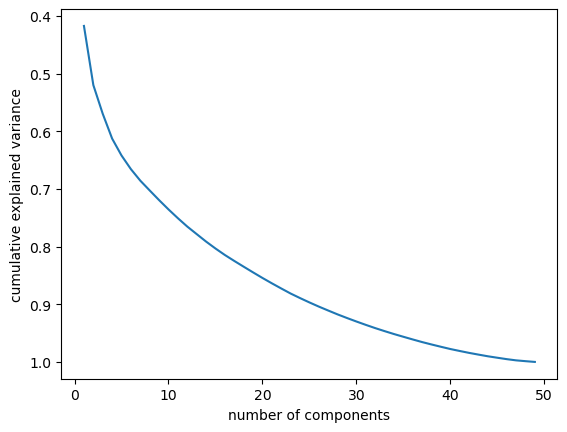

In [7]:
x = list(range(1, 1 + len(pca4.explained_variance_ratio_)))
plt.plot(x, np.cumsum(pca4.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.gca().invert_yaxis()
plt.show()

In [8]:
X = questions_data
print(X)
X_scaled = preprocessing.StandardScaler().fit_transform(X)
pca1 = decomposition.PCA(n_components=2)
res4 = pca1.fit_transform(X_scaled)
pca1.explained_variance_ratio_

     530  531  533  534  535  537  538  540  541  543  ...  8a  8b  9a  9b  \
0     -1   -2    1   -2    2    1   -2    1    1    2  ...   1   0   2   0   
1      2    2   -1   -2   -1   -2    1   -2    2   -2  ...   0   0  -2   0   
2      2    1   -2   -2    1   -2    1   -1    1   -1  ...   1   1  -1  -2   
3      2    1   -2   -1    1    1    1    1    1   -2  ...   2   2  -2   2   
4      1    1   -2    2   -2    1   -2    1    2   -2  ...   1   0  -2   0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ..  ..  ..  ..   
862    1    1    1   -2    2   -1    1   -2    1    1  ...   2   1   1   2   
863    1   -2   -2   -2    1   -2   -1   -2   -2   -2  ...   1   0  -1   0   
864    1    1    1   -2    2   -1    1   -1   -1    1  ...   1   0  -1   0   
865    1   -1    1   -2    1   -1   -1   -1   -1    1  ...   0   0   0   0   
866    1    1   -1   -2    1   -1    1   -1    1   -1  ...   1   1  -2  -1   

     10a  10b  11a  11b  12a  12b  
0      1   -2   -2    1    

array([0.41737636, 0.10259865])

In [9]:
from sklearn.decomposition import PCA
# keep the first ten principal components of the data
pca = decomposition.PCA(n_components = 10)
# fit PCA model to beast cancer data
pca.fit(X_scaled)

# transform data onto the first ten principal components
X_pca = pca.transform(questions_data)
print("Original shape: {}".format(str(X.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

Original shape: (867, 49)
Reduced shape: (867, 10)


c:\Users\sofia\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


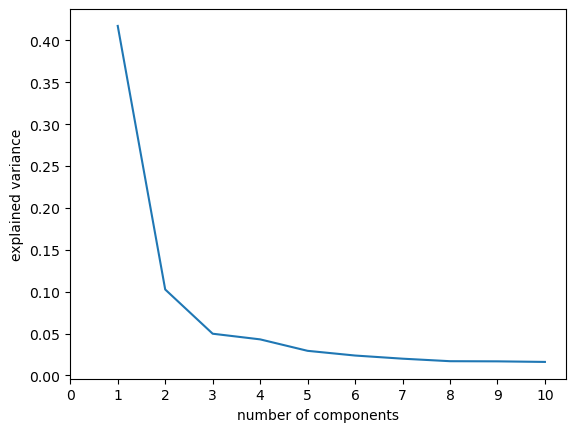

In [10]:
#Explained variance
plt.plot(list(range(1, 1 + len(pca.explained_variance_ratio_))), pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.xticks(np.arange(0, 1 + len(pca.explained_variance_ratio_), step=1))
plt.show()

In [11]:
from sklearn.decomposition import PCA
# keep the first two principal components of the data
pca = decomposition.PCA(n_components=2)
pca.fit(X_scaled)
# transform data onto the first two principal components
X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

Original shape: (867, 49)
Reduced shape: (867, 2)


In [12]:
pca.explained_variance_ratio_

array([0.41737636, 0.10259865])

array([0.45607901, 0.11056386])

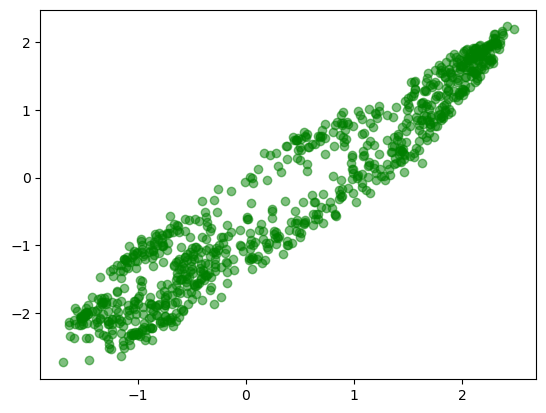

In [13]:
pca2 = decomposition.PCA(n_components=2)
res = pca2.fit_transform(X)
flat = pca2.inverse_transform(res)
plt.scatter(flat[:, 0], flat[:, 1], c='g', alpha=.5);
pca2.explained_variance_ratio_

In [14]:
print("PCA components:\n{}".format(pca.components_))
pca.explained_variance_ratio_
# pca1.explained_variance_ratio_
pca2.explained_variance_ratio_


PCA components:
[[-0.19064057 -0.18701591  0.12593721  0.04447839  0.15513898  0.19028423
  -0.15026319  0.17440399 -0.17172216  0.18589295 -0.16781961  0.1136901
   0.14115873 -0.04512024 -0.17628124 -0.18855513  0.11275536 -0.11796376
   0.01533354  0.16574291  0.12014954 -0.13966836 -0.17627888 -0.12886574
  -0.1561081  -0.1714181  -0.17225463 -0.13953998 -0.12449377  0.17047237
  -0.18877783 -0.18884915 -0.06188245  0.04769846  0.01124495 -0.16629091
   0.16320559  0.1551616   0.1053235  -0.050785   -0.0763627   0.17268654
  -0.08390767  0.1656754  -0.11798968 -0.15871925  0.15866409  0.10586157
  -0.07231144]
 [-0.05808734  0.05758966  0.18496243  0.20144705  0.03183622 -0.0888619
   0.07897535 -0.13758677 -0.0640313   0.00434791 -0.06232566 -0.14963501
  -0.14091139 -0.15011287  0.01211795 -0.02064151  0.29383592 -0.00148747
   0.27280765  0.20674982 -0.29797872  0.12424667 -0.10772719 -0.09384769
   0.06219024 -0.12543664 -0.12100571  0.07476874 -0.10039192 -0.01793171
  -0.1262

array([0.45607901, 0.11056386])

In [15]:
# Get the names of the features in the first principal component
component_one_features = questions_data.columns[np.abs(pca.components_[0]).argsort()[::-1]]

# Print the names of the features in the first principal component
print("Features in Principal Component 1:")
print(component_one_features)


component_two_features = questions_data.columns[np.abs(pca.components_[1]).argsort()[::-1]]
print("Features in Principal Component 2:")
print(component_two_features)


Features in Principal Component 1:
Index(['530', '537', '4a', '3b', '550', '531', '543', '548', '559', '540',
       '9a', '1b', '541', '1a', '3a', '544', '6a', '555', '10a', '6b', '11a',
       '11b', '563', '7a', '535', '538', '546', '557', '2a', '561', '533',
       '2b', '556', '10b', '552', '545', '551', '12a', '7b', '9b', '8b', '12b',
       '4b', '8a', '5a', '547', '534', '553', '5b'],
      dtype='object')
Features in Principal Component 2:
Index(['10b', '556', '551', '553', '4b', '5a', '6a', '6b', '555', '534', '533',
       '5b', '547', '545', '546', '540', '7a', '3b', '7b', '1a', '557', '1b',
       '12a', '11a', '559', '2b', '561', '4a', '537', '10a', '11b', '538',
       '12b', '2a', '541', '544', '563', '530', '531', '9b', '8a', '535',
       '550', '3a', '8b', '548', '9a', '543', '552'],
      dtype='object')


In [16]:
# Get the indices of the two features with the highest variance ratio
top_two_indices_pca1 = np.abs(pca.components_[0]).argsort()[-5:]

# Get the names of the two features with the highest variance ratio
top_two_features_pca1 = questions_data.columns[top_two_indices_pca1]

# Print the names of the two features with the highest variance ratio
print("PCA1: Top two features with the highest variance ratio:")
print(top_two_features_pca1)


# Get the indices of the two features with the highest variance ratio
top_two_indices_pca2 = np.abs(pca.components_[1]).argsort()[-5:]

# Get the names of the two features with the highest variance ratio
top_two_features_pca2 = questions_data.columns[top_two_indices_pca2]

# Print the names of the two features with the highest variance ratio
print("PCA2: Top two features with the highest variance ratio:")
print(top_two_features_pca2)

PCA1: Top two features with the highest variance ratio:
Index(['550', '3b', '4a', '537', '530'], dtype='object')
PCA2: Top two features with the highest variance ratio:
Index(['4b', '553', '551', '556', '10b'], dtype='object')


In [25]:
# Get the indices of the two features with the highest variance ratio
top_two_indices_pca1 = np.abs(pca.components_[0]).argsort()[-2:]

# Get the names of the two features with the highest variance ratio
top_two_features_pca1 = questions_data.columns[top_two_indices_pca1]

# Get the variance ratios of the top two features for PCA1
top_two_ratios_pca1 = np.abs(pca.components_[0][top_two_indices_pca1])

# Calculate the difference of ratios for PCA1
diff_ratio_pca1 = top_two_ratios_pca1[1] - top_two_ratios_pca1[0]

print("PCA1: Top two features with the highest variance ratio:")
for feature, ratio in zip(top_two_features_pca1, top_two_ratios_pca1):
    print(f"{feature}: {ratio}")

print(f"Difference of ratios for PCA1: {diff_ratio_pca1}\n")

# Get the indices of the two features with the highest variance ratio
top_two_indices_pca2 = np.abs(pca.components_[1]).argsort()[-2:]

# Get the names of the two features with the highest variance ratio
top_two_features_pca2 = questions_data.columns[top_two_indices_pca2]

# Get the variance ratios of the top two features for PCA2
top_two_ratios_pca2 = np.abs(pca.components_[1][top_two_indices_pca2])

# Calculate the difference of ratios for PCA2
diff_ratio_pca2 = top_two_ratios_pca2[1] - top_two_ratios_pca2[0]

print("PCA2: Top two features with the highest variance ratio:")
for feature, ratio in zip(top_two_features_pca2, top_two_ratios_pca2):
    print(f"{feature}: {ratio}")

print(f"Difference of ratios for PCA2: {diff_ratio_pca2}")


PCA1: Top two features with the highest variance ratio:
550: 0.20506631450803267
531: 0.2054161205930766
Difference of ratios for PCA1: 0.0003498060850439244

PCA2: Top two features with the highest variance ratio:
10b: 0.3550037588999357
556: 0.35604855631819826
Difference of ratios for PCA2: 0.0010447974182625774


Examples of the questions that we will be using for plotting

In [17]:
import pandas as pd

# Columns for dr_questions and tv_questions
dr_columns = ['ID', 'Question', 'Title']
tv_columns = ['id', 'header', 'question']

# Read the Excel files
dr_questions = pd.read_excel('drq.xlsx', usecols=dr_columns)
tv_questions = pd.read_excel('tv2q.xlsx', usecols=tv_columns)

# Define the IDs for extraction
dr1 = [550, 537, 530]
tv1 = ['3b', '4a']

# Extract rows from dr_questions and tv_questions
pca1 = dr_questions[dr_questions['ID'].isin(dr1)]
pca1_tv = tv_questions[tv_questions['id'].isin(tv1)]
pca1_tv = pca1_tv.rename(columns={'id': 'ID', 'header': 'Title', 'question': 'Question'})
result = pd.concat([pca1, pca1_tv], ignore_index=True)
result.style

,ID,Title,Question
0,530,KLIMA OG ENERGI,Danmark skal bruge flere penge på at styrke tog- og busdrift frem for at bygge nye motorveje
1,537,VELFÆRD,"Det er okay, at den økonomiske ulighed stiger, så længe danskerne generelt bliver rigere"
2,550,ARBEJDSMARKED OG ØKONOMI,"Der skal indføres kvoter, der sikrer mindst 30 procent kvinder i virksomheders bestyrelser"
3,3b,Udenrigs- og forsvarspolitik,Ulandsbistanden bør hæves.
4,4a,Økonomi,Den økonomiske ulighed i det danske samfund bør mindskes.


In [18]:
import pandas as pd

# Columns for dr_questions and tv_questions
dr_columns = ['ID', 'Question', 'Title']
tv_columns = ['id', 'header', 'question']

# Read the Excel files
dr_questions = pd.read_excel('drq.xlsx', usecols=dr_columns)
tv_questions = pd.read_excel('tv2q.xlsx', usecols=tv_columns)

# Define the IDs for extraction
dr1 = [553, 551, 556]
tv1 = ['4b', '10b']

# Extract rows from dr_questions and tv_questions
pca1 = dr_questions[dr_questions['ID'].isin(dr1)]
pca1_tv = tv_questions[tv_questions['id'].isin(tv1)]
pca1_tv = pca1_tv.rename(columns={'id': 'ID', 'header': 'Title', 'question': 'Question'})
result = pd.concat([pca1, pca1_tv], ignore_index=True)
result.style

,ID,Title,Question
0,551,EU OG UDENRIGS,Der skal være permanent grænsekontrol mellem Danmark og Tyskland
1,553,UDDANNELSE,Der skal udflyttes flere uddannelsespladser fra de store byer
2,556,ARBEJDSMARKED OG ØKONOMI,Den såkaldte Arne-pension skal afskaffes
3,4b,Økonomi,"Staten bør i højere grad kompensere danskerne for de stigende priser, som inflationen har medført."
4,10b,Socialområdet,"Den såkaldte Arne-pension, der giver mulighed for tidligere pension, skal bibeholdes, selvom der er mangel på arbejdskraft."


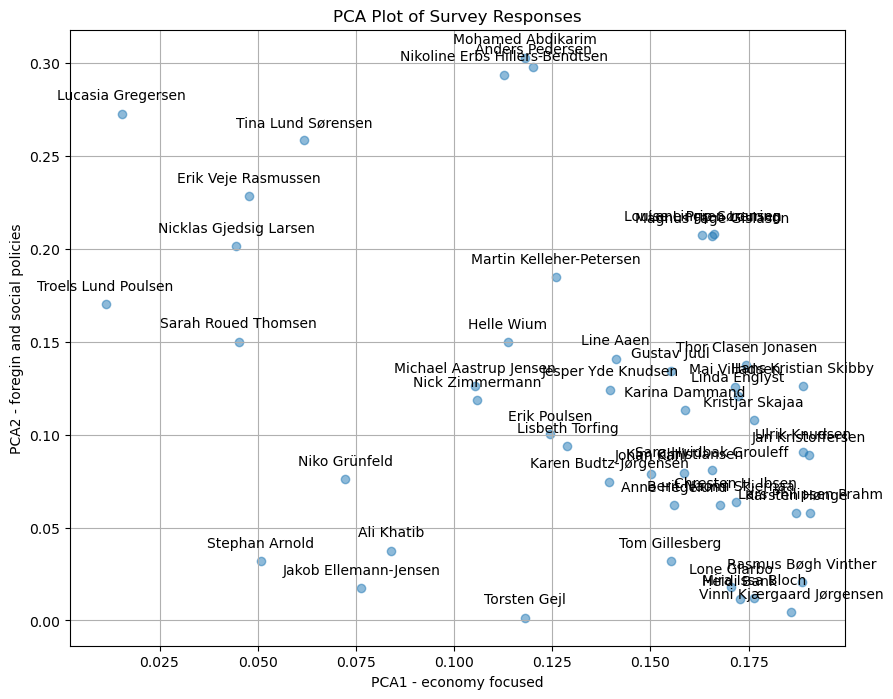

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you already have pca1, pca2, and names defined
pca1 = np.abs(pca.components_[0])
pca2 = np.abs(pca.components_[1])
names = data['navn']
answers = questions_data

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(pca1, pca2, alpha=0.5)

# Annotate points with names
for i in range(len(pca1)):
    plt.annotate(names[i], (pca1[i], pca2[i]), textcoords="offset points", xytext=(0,10), ha='center')

#since pca 1 is more economical questions we will mention that
plt.xlabel('PCA1 - economy focused')
#since pca 2 is more foerign politics questions we will mention that
plt.ylabel('PCA2 - foregin and social policies')
plt.title('PCA Plot of Survey Responses')
plt.grid(True)
plt.show()


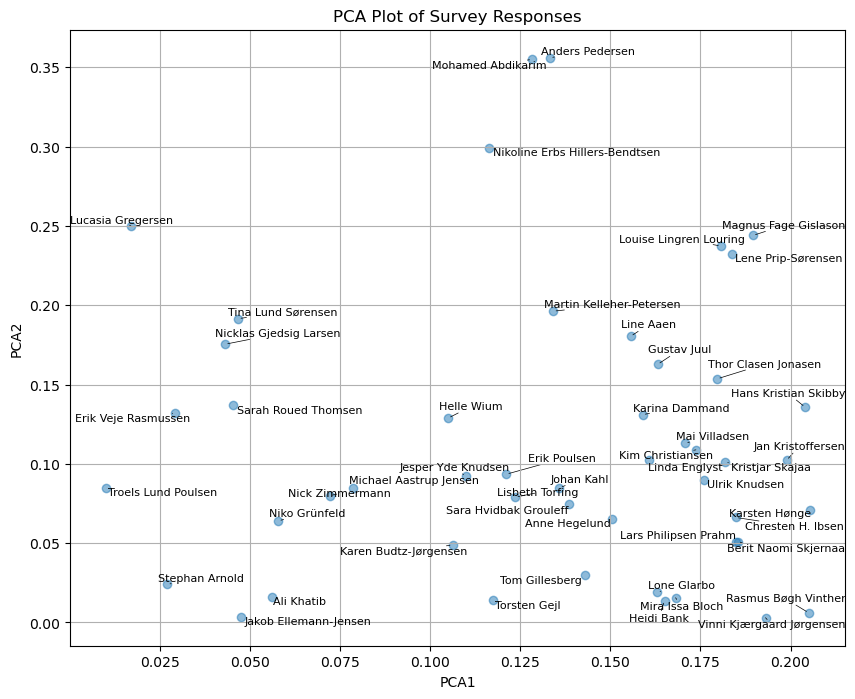

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Assuming you already have pca1, pca2, and names defined
pca1 = np.abs(pca.components_[0])
pca2 = np.abs(pca.components_[1])
names = data['navn']
answers = questions_data

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(pca1, pca2, alpha=0.5)

# Annotate points with names
texts = [plt.text(pca1[i], pca2[i], names[i], ha='center', va='center', fontsize=8) for i in range(len(pca1))]
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA Plot of Survey Responses')
plt.grid(True)
plt.show()


trying to plot with the features that have the highest variance

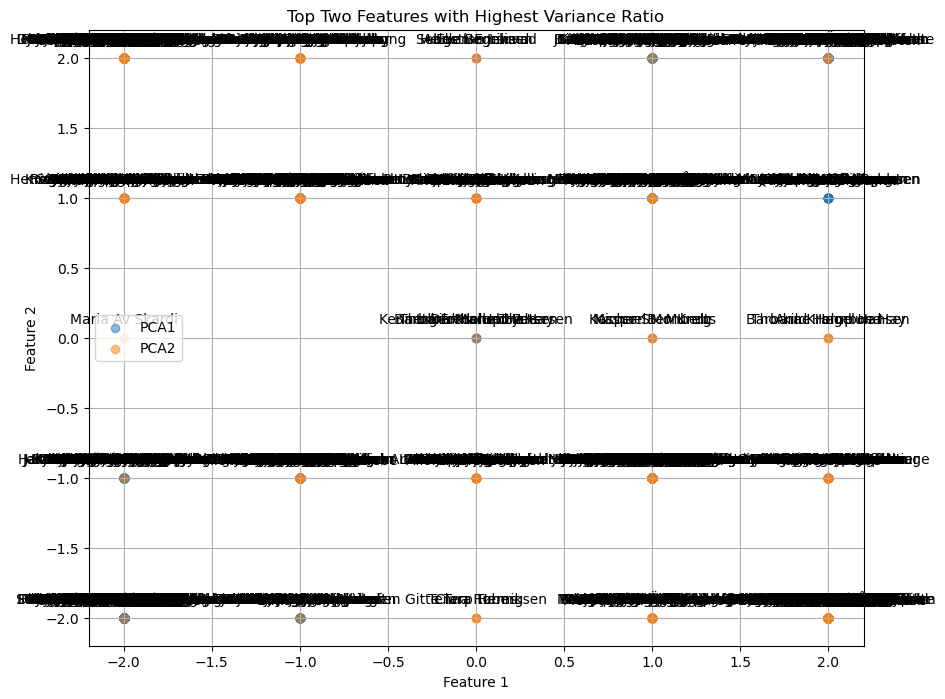

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Get the indices of the two features with the highest variance ratio for PCA1
top_two_indices_pca1 = np.abs(pca.components_[0]).argsort()[-2:]
top_two_features_pca1 = questions_data.columns[top_two_indices_pca1]
top_two_ratios_pca1 = np.abs(pca.components_[0][top_two_indices_pca1])
top_two_data_pca1 = questions_data[top_two_features_pca1]

top_two_indices_pca2 = np.abs(pca.components_[1]).argsort()[-2:]
top_two_features_pca2 = questions_data.columns[top_two_indices_pca2]
top_two_ratios_pca2 = np.abs(pca.components_[1][top_two_indices_pca2])
top_two_data_pca2 = questions_data[top_two_features_pca2]


# Plot
plt.figure(figsize=(10, 8))
plt.scatter(top_two_data_pca1.iloc[:, 0], top_two_data_pca1.iloc[:, 1], alpha=0.5, label="PCA1")
plt.scatter(top_two_data_pca2.iloc[:, 0], top_two_data_pca2.iloc[:, 1], alpha=0.5, label="PCA2")

# Annotate points with names
for i, name in enumerate(names):
    plt.annotate(name, (top_two_data_pca1.iloc[i, 0], top_two_data_pca1.iloc[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.annotate(name, (top_two_data_pca2.iloc[i, 0], top_two_data_pca2.iloc[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Top Two Features with Highest Variance Ratio')
plt.grid(True)
plt.legend()
plt.show()
